In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from datetime import datetime, time
import numpy as np
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import lightgbm as lgb
!pip3 install catboost
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split


plt.style.use('ggplot')

In [ ]:
df = pd.read_csv('/path/Dataset_publico.csv', delimiter=';',index_col="ID")


In [ ]:
df = df.dropna()

## MODELAGEM DOS DADOS

In [ ]:
df["TS_INC_EPR"] = pd.to_datetime(df["TS_INC_EPR"])
df["TS_INC_CHMD"] = pd.to_datetime(df["TS_INC_CHMD"])

In [ ]:
#Criando variáveis de interesse
df['HH_INC'] = df['TS_INC_EPR'].dt.strftime('%H').astype('int')
df["DiaSem"] = df['TS_INC_EPR'].dt.strftime('%a')
df["Dia"] = df['TS_INC_EPR'].dt.strftime('%-d')
df["Data"] = df['TS_INC_EPR'].dt.strftime('%x')
df["Mes"] = df['TS_INC_EPR'].dt.strftime('%B')
df["Espera"] = df["TS_INC_CHMD"]- df['TS_INC_EPR']

In [ ]:
#Conforme caracterização do problema criando variável categórica para identificar atendimentos com tempo superior a 15min
df["Estouro"] = np.where(df.Espera.dt.total_seconds() > 900 , 1, 0)

In [ ]:
#drop dezembro dia 24
start_date = pd.to_datetime('12/24/2020 00:00')
end_date = pd.to_datetime('12/24/2020 23:59')

df.drop(df.loc[(df['TS_INC_EPR'] > start_date) & (df['TS_INC_EPR'] < end_date)].index, inplace=True)

In [ ]:
#Conforme caracterização do problema alterando atendimentos iniciados antes do horário de atendimento e após o horário de atendimento para serem contabilizados como dentro do horário
conditions = [
    (df['HH_INC'] < 10),
    (df['HH_INC'] > 14),
    ]

# lista de valores para comparar com condição
values = [10, 14]

# nova coluna com valores que satisfaçam condição
df['HH'] = np.select(conditions, values)

# Novo Dataframe
df.tail()

,ID_UOR,TS_INC_EPR,TS_INC_CHMD,HH_INC,DiaSem,Dia,Data,Mes,Espera,Estouro,HH
ID,,,,,,,,,,,
376677,24,2021-07-30 13:05:56,2021-07-30 13:06:35,13,Fri,30,07/30/21,July,0 days 00:00:39,0,0
376678,24,2021-07-30 13:12:09,2021-07-30 13:15:53,13,Fri,30,07/30/21,July,0 days 00:03:44,0,0
376679,24,2021-07-30 13:17:08,2021-07-30 13:17:31,13,Fri,30,07/30/21,July,0 days 00:00:23,0,0
376680,24,2021-07-30 13:27:15,2021-07-30 13:27:29,13,Fri,30,07/30/21,July,0 days 00:00:14,0,0
376681,24,2021-07-30 13:30:20,2021-07-30 13:34:28,13,Fri,30,07/30/21,July,0 days 00:04:08,0,0


In [ ]:
#Transformando horários que foram alterados no passo anterior
df['HH'] = np.where(df.HH == 0, df.HH_INC, df.HH)

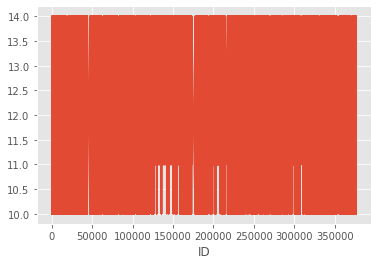

In [ ]:
#confirmando que todos os atendimentos estão entre 10h e 14h
df.HH.plot()

In [ ]:
#Groupby dos atendimentos realizados no dia por horário
df2 = df.groupby(["ID_UOR",'Data','HH', 'Dia', 'DiaSem','Mes']).agg({'Estouro':['sum', 'count']})
a = df2.unstack().stack().reset_index()
a.columns = ['ID_UOR','Data','HH','Dia','DiaSem','Mes', 'sum','count']


In [ ]:
#Cálculo do percentual de atendimentos que ficou acima do prazo
a['PC_ACI_PZ'] = round((a['sum'] / a['count']) * 100, 2)
abt = a[['ID_UOR', 'HH', 'Dia', 'DiaSem', 'Mes']].astype('str')
abt['PC_ACI_PZ'] = a['PC_ACI_PZ']


In [ ]:
#Feature engineering - adicionando percentual de atendimentos fora do prazo para determinado dia da semana, dia do mês e mês
#Objetivo é identificar padrões de demanda para essas variáveis
MEDIA_DIA_SEMANA = abt.groupby(["ID_UOR",'HH', 'DiaSem']).mean('PC_ACI_PZ').unstack().stack().reset_index()
MEDIA_MES = abt.groupby(["ID_UOR",'HH', 'Mes']).mean('PC_ACI_PZ').unstack().stack().reset_index()
MEDIA_DIA = abt.groupby(["ID_UOR",'HH', 'Dia']).mean('PC_ACI_PZ').unstack().stack().reset_index()

MIN_DIA_SEMANA = abt.groupby(["ID_UOR",'HH', 'DiaSem']).min('PC_ACI_PZ').unstack().stack().reset_index()
MIN_MES = abt.groupby(["ID_UOR",'HH', 'Mes']).min('PC_ACI_PZ').unstack().stack().reset_index()
MIN_DIA = abt.groupby(["ID_UOR",'HH', 'Dia']).min('PC_ACI_PZ').unstack().stack().reset_index()

MAX_DIA_SEMANA = abt.groupby(["ID_UOR",'HH', 'DiaSem']).max('PC_ACI_PZ').unstack().stack().reset_index()
MAX_MES = abt.groupby(["ID_UOR",'HH', 'Mes']).max('PC_ACI_PZ').unstack().stack().reset_index()
MAX_DIA = abt.groupby(["ID_UOR",'HH', 'Dia']).max('PC_ACI_PZ').unstack().stack().reset_index()

MEDIA_DIA_SEMANA.columns = ['ID_UOR', 'HH', 'DiaSem', 'PC_ACI_PZ_SMN']
MEDIA_DIA.columns = ['ID_UOR', 'HH', 'Dia', 'PC_ACI_PZ_DIA']
MEDIA_MES.columns = ['ID_UOR', 'HH', 'Mes', 'PC_ACI_PZ_MES']

MIN_DIA_SEMANA.columns = ['ID_UOR', 'HH', 'DiaSem', 'PC_ACI_PZ_MINSMN']
MIN_DIA.columns = ['ID_UOR', 'HH', 'Dia', 'PC_ACI_PZ_MINDIA']
MIN_MES.columns = ['ID_UOR', 'HH', 'Mes', 'PC_ACI_PZ_MINMES']


MAX_DIA_SEMANA.columns = ['ID_UOR', 'HH', 'DiaSem', 'PC_ACI_PZ_MAXSMN']
MAX_DIA.columns = ['ID_UOR', 'HH', 'Dia', 'PC_ACI_PZ_MAXDIA']
MAX_MES.columns = ['ID_UOR', 'HH', 'Mes', 'PC_ACI_PZ_MAXMES']

In [ ]:
abt['atendimentos'] = a['count']

In [ ]:
abt.head(1)

,ID_UOR,HH,Dia,DiaSem,Mes,PC_ACI_PZ,atendimentos
0,0,10,4,Mon,January,0.0,14.0


## Comportamento Demanda Mensal

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


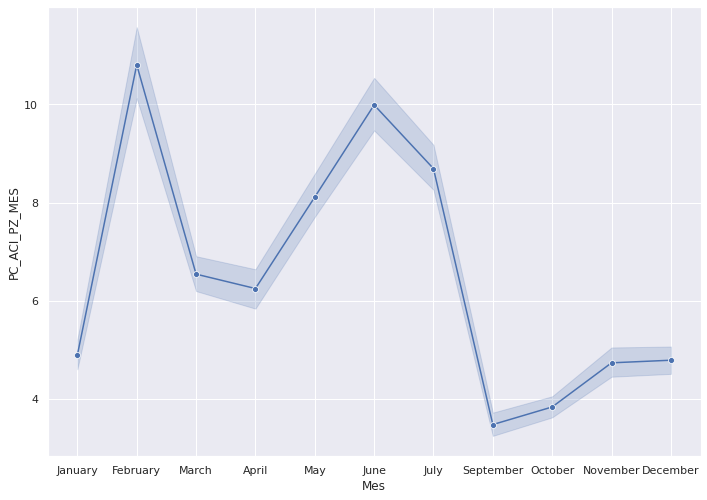

In [ ]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
abt['Mes'] = pd.Categorical(abt['Mes'], categories=['January', 'February', 'March', 'April','May', 'June', 'July','September', 'October', 'November',  'December' ], ordered=True)
sns.lineplot(abt.Mes, abt.PC_ACI_PZ_MES, marker='o')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


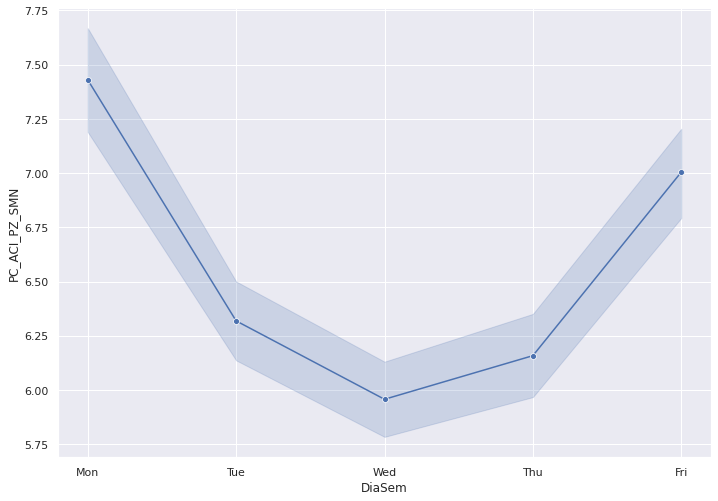

In [ ]:
abt['DiaSem'] = pd.Categorical(abt['DiaSem'], categories=['Mon', 'Tue', 'Wed', 'Thu','Fri'], ordered=True)
sns.lineplot(abt.DiaSem, abt.PC_ACI_PZ_SMN, marker='o')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


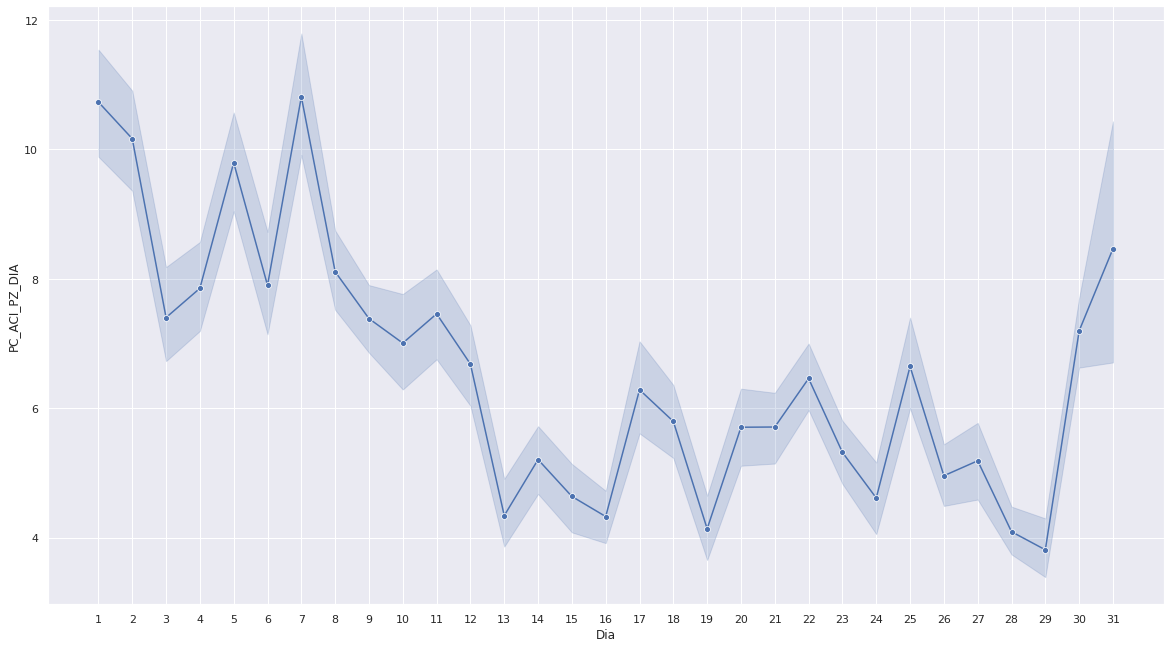

In [ ]:
sns.set(rc={'figure.figsize':(20,11)})
abt['Dia'] = pd.Categorical(abt['Dia'], categories=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31'], ordered=True)
sns.lineplot(abt.Dia, abt.PC_ACI_PZ_DIA, marker='o')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


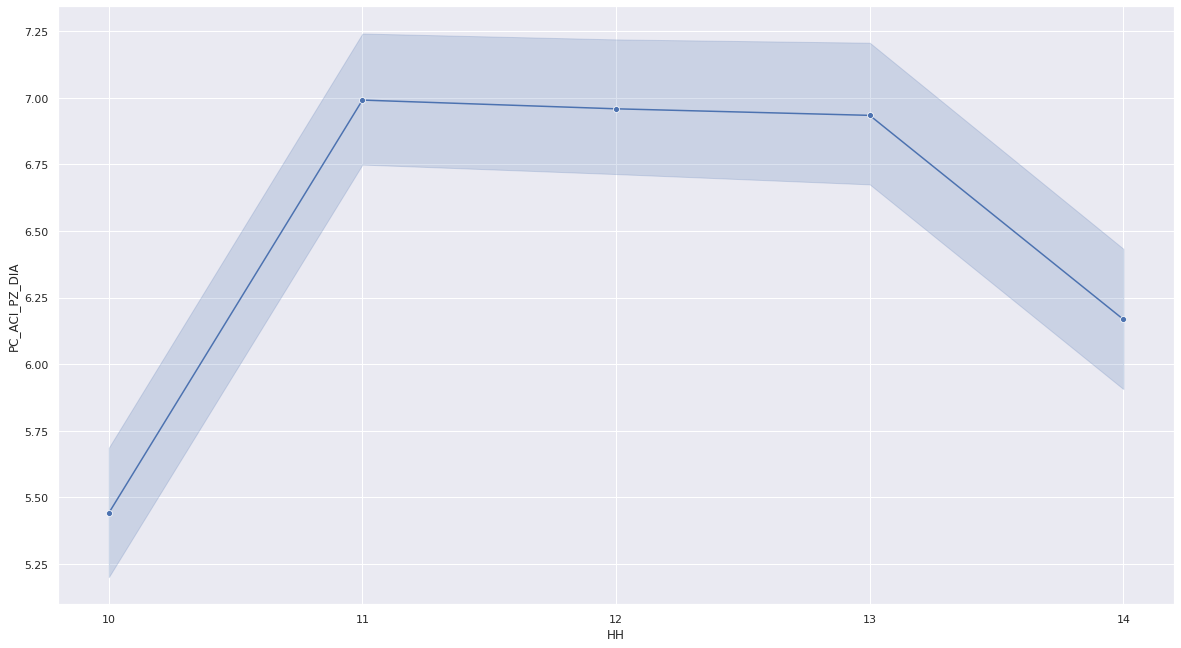

In [ ]:
abt['HH'] = pd.Categorical(abt['HH'], categories=['10', '11', '12', '13', '14'], ordered=True)
sns.lineplot(abt.HH, abt.PC_ACI_PZ_DIA, marker='o')

##JOIN

In [ ]:
abt = pd.merge(abt, MEDIA_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'])
abt = pd.merge(abt, MEDIA_DIA, on=["ID_UOR",'HH', 'Dia'])
abt = pd.merge(abt, MEDIA_MES, on=["ID_UOR",'HH', 'Mes'])

abt = pd.merge(abt, MIN_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'])
abt = pd.merge(abt, MIN_DIA, on=["ID_UOR",'HH', 'Dia'])
abt = pd.merge(abt, MIN_MES, on=["ID_UOR",'HH', 'Mes'])

abt = pd.merge(abt, MAX_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'])
abt = pd.merge(abt, MAX_DIA, on=["ID_UOR",'HH', 'Dia'])
abt = pd.merge(abt, MAX_MES, on=["ID_UOR",'HH', 'Mes'])

In [ ]:
abt.head()

,ID_UOR,HH,Dia,DiaSem,Mes,PC_ACI_PZ,atendimentos,PC_ACI_PZ_SMN,PC_ACI_PZ_DIA,PC_ACI_PZ_MES,PC_ACI_PZ_MINSMN,PC_ACI_PZ_MINDIA,PC_ACI_PZ_MINMES,PC_ACI_PZ_MAXSMN,PC_ACI_PZ_MAXDIA,PC_ACI_PZ_MAXMES
0,0,10,4,Mon,January,0.00,14.0,3.347907,6.690000,1.5705,0.0,0.0,0.0,22.22,40.00,23.08
1,0,10,11,Mon,January,0.00,15.0,3.347907,3.541250,1.5705,0.0,0.0,0.0,22.22,20.00,23.08
2,0,10,18,Mon,January,0.00,15.0,3.347907,5.745000,1.5705,0.0,0.0,0.0,22.22,28.57,23.08
3,0,10,25,Mon,January,8.33,24.0,3.347907,5.951429,1.5705,0.0,0.0,0.0,22.22,33.33,23.08
4,0,10,7,Thu,January,0.00,13.0,2.970667,1.098571,1.5705,0.0,0.0,0.0,33.33,7.69,23.08


##DUMMIES

In [ ]:
abt = pd.get_dummies(abt, prefix=['ID_UOR', 'HH', 'Dia', 'DiaSem','Mes'])

## Train Test split + sklearn imports

In [ ]:


X = abt.iloc[:,1:]
y = abt['PC_ACI_PZ']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)



## LGBM

In [ ]:

clf = lgb.LGBMRegressor()
clf.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#RESULTADO COM MÉDIA DO MÊS
y_pred=clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print(metrics.r2_score(y_train, y_pred_train))
print(metrics.mean_absolute_error(y_train, y_pred_train))
print(metrics.mean_squared_error(y_train, y_pred_train))
print('---------------------------------------------------')
print(metrics.r2_score(y_test, y_pred))
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))

0.7133911262736912
4.608754210800728
73.96131736868968
---------------------------------------------------
0.5207606703662214
5.905072110995992
134.33932655747063


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


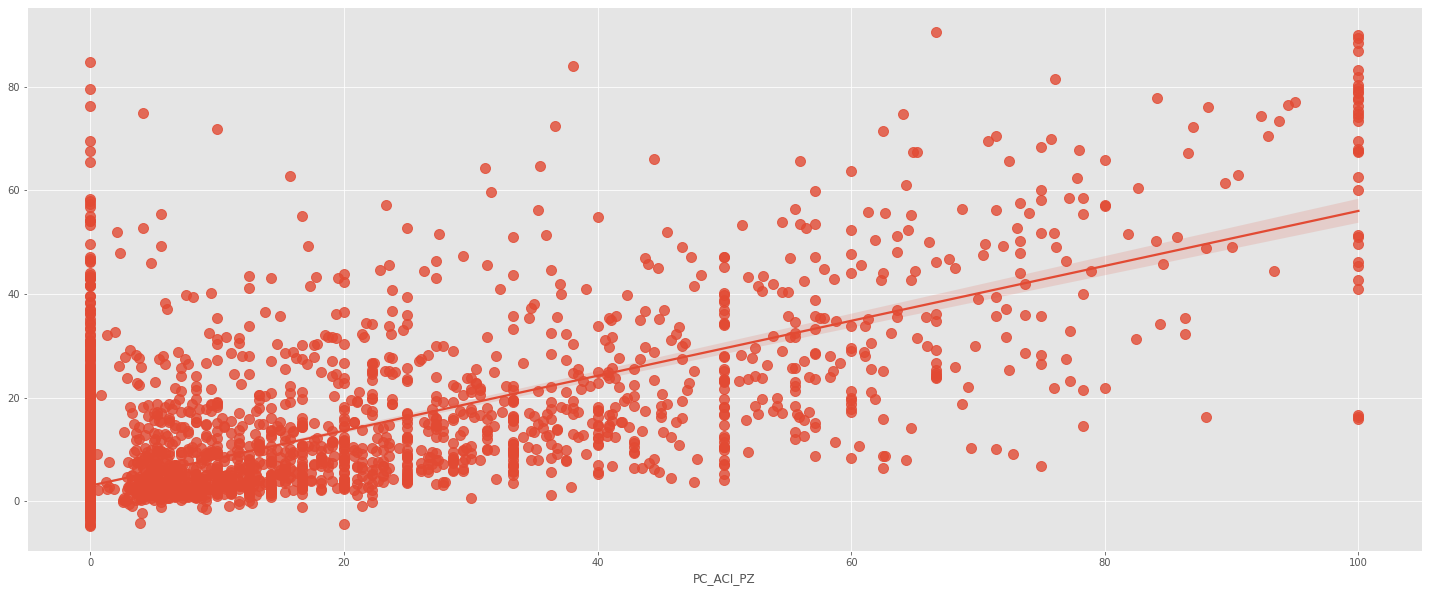

In [ ]:
plt.figure(figsize=(25,10))
sns.regplot(y_test, y_pred, fit_reg=True, scatter_kws={"s": 100})

##LGBM otimização

In [ ]:


parametros = {
    'max_depth' : [-1],
    'num_leaves' : [20, 31, 50],
    'learning_rate' : [0.01, 0.05, 0.1],
    'n_estimators' : [500, 600, 700]
}

lgbm_model_tunned = GridSearchCV(clf, parametros, verbose=2, scoring = 'neg_mean_squared_error', cv=5, n_jobs=-1)
lgbm_model_tunned.fit(X_train,y_train)

In [ ]:
best_params = lgbm_model_tunned.best_params_
print(f'Hiperparâmetros = {best_params}')

Hiperparâmetros = {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 31}


In [ ]:
y_pred_tunned = lgbm_model_tunned.predict(X_test)

print(metrics.r2_score(y_test, y_pred_tunned))
print(metrics.mean_absolute_error(y_test, y_pred_tunned))
print(metrics.mean_squared_error(y_test, y_pred))

0.5236760230068935
5.948145251789212
134.33932655747063


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


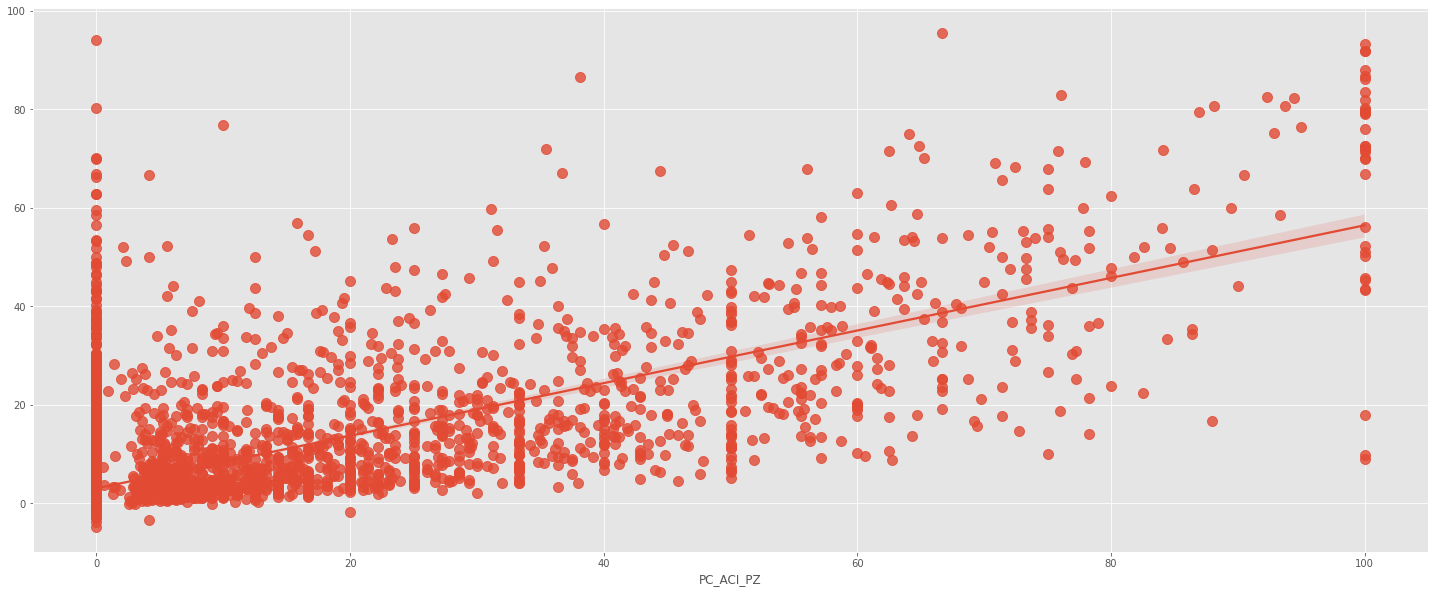

In [ ]:
plt.figure(figsize=(25,10))
sns.regplot(y_test, y_pred_tunned, fit_reg=True, scatter_kws={"s": 100})

##CATBOOST

In [ ]:
model = CatBoostRegressor()
# Fit model
model.fit(X_train, y_train)
# Get predictions
preds = model.predict(X_test)
print(metrics.mean_squared_error(y_test, preds))


In [ ]:
parametros = {
    
    'num_leaves' : [25, 29, 31, 35, 40],
    'learning_rate' : [ 0.01, 0.05, 0.1, 0.5],
    'n_estimators' : [400, 500, 700],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [5,7,9]
}

cat_model_tunned = GridSearchCV(model, parametros, verbose=2, scoring = 'neg_mean_squared_error', cv=5, n_jobs=-1)
cat_model_tunned.fit(X_train,y_train)

In [ ]:
best_params = cat_model_tunned.best_params_
print(f'Hiperparâmetros = {best_params}')
preds = cat_model_tunned.predict(X_test)
print(metrics.mean_squared_error(y_test, preds))

Hiperparâmetros = {'depth': 6, 'l2_leaf_reg': 7, 'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 31}
120.97944153382588


## DEEP LEARNING

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.embeddings import Embedding

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

In [ ]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model = Sequential()

model.add(Dense(100))
model.add(Dense(50, activation="relu", kernel_regularizer='l2'))
model.add(Dense(10, activation="relu", kernel_regularizer='l2'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',loss=root_mean_squared_error, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=1000, verbose=2, batch_size=16, validation_data=(X_test, y_test),callbacks =[earlystopping])

In [ ]:
y_test_deep_pred = model.predict(X_test)
y_train_deep_pred = model.predict(X_train)

### 1000 epoch earlystopping 10 patience 100 50 10 1

In [ ]:
mae_test_deep = mean_absolute_error(y_test, y_test_deep_pred)
print(metrics.r2_score(y_test, y_test_deep_pred))
print("MAE Deep Learning (Test): ", mae_test_deep)
print(metrics.mean_squared_error(y_test, y_test_deep_pred))


0.5887649341499421
MAE Deep Learning (Test):  5.3376709857390665
115.27651924004357


# Submissão

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/trabalho_pratico/X.csv', delimiter=';',index_col="ID")

In [ ]:
sub["DT"] = pd.to_datetime(sub["DT"])
sub["HH_INC"] = pd.to_datetime(sub["HH_INC"])

Como não havia o mês de Agosto na amostra havia a opção de descartar os valores médios dos meses mas houve uma piora significativa do modelo. Por esse motivo optei por realizar a submissão utilizando os dados históricos do mês anterior e do próximo mês. Pelo estudo da amostra o mais provável é que o mês de agosto apresentasse uma ligeira redução em relação ao mês de Julho e fosse ligeiramente superior ao mês de Setembro. 

In [ ]:
sub['HH'] = sub['HH_INC'].dt.strftime('%H')
sub["DiaSem"] = sub['DT'].dt.strftime('%a')
sub["Dia"] = sub['DT'].dt.strftime('%-d')

sub2 = sub.copy()

In [ ]:
sub["Mes"] = 'July'
sub2["Mes"] = 'September'

In [ ]:
sub.drop(['DT', 'HH_INC', 'HH_FIM'], axis=1, inplace=True)

In [ ]:
sub2.drop(['DT', 'HH_INC', 'HH_FIM'], axis=1, inplace=True)

In [ ]:
sub = sub[['ID_UOR', 'HH', 'DiaSem', 'Dia', 'Mes']].astype('str')
sub2 = sub2[['ID_UOR', 'HH', 'DiaSem', 'Dia', 'Mes']].astype('str')

In [ ]:
#TRATAR DIA DO MÊS SEM DADOS PARA JULHO
sub = pd.merge(sub, MEDIA_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub = pd.merge(sub, MEDIA_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub = pd.merge(sub, MEDIA_MES, on=["ID_UOR",'HH', 'Mes'],how='left')


sub = pd.merge(sub, MIN_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub = pd.merge(sub, MIN_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub = pd.merge(sub, MIN_MES, on=["ID_UOR",'HH', 'Mes'],how='left')


sub = pd.merge(sub, MAX_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub = pd.merge(sub, MAX_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub = pd.merge(sub, MAX_MES, on=["ID_UOR",'HH', 'Mes'],how='left')



In [ ]:
sub2 = pd.merge(sub2, MEDIA_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub2 = pd.merge(sub2, MEDIA_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub2 = pd.merge(sub2, MEDIA_MES, on=["ID_UOR",'HH', 'Mes'],how='left')


sub2 = pd.merge(sub2, MIN_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub2 = pd.merge(sub2, MIN_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub2 = pd.merge(sub2, MIN_MES, on=["ID_UOR",'HH', 'Mes'],how='left')


sub2 = pd.merge(sub2, MAX_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub2 = pd.merge(sub2, MAX_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub2 = pd.merge(sub2, MAX_MES, on=["ID_UOR",'HH', 'Mes'],how='left')


In [ ]:
sub.isnull().sum()

ID_UOR                0
HH                    0
DiaSem                0
Dia                   0
Mes                   0
PC_ACI_PZ_SMN        74
PC_ACI_PZ_DIA       180
PC_ACI_PZ_MES       286
PC_ACI_PZ_MINSMN     74
PC_ACI_PZ_MINDIA    180
PC_ACI_PZ_MINMES    286
PC_ACI_PZ_MAXSMN     74
PC_ACI_PZ_MAXDIA    180
PC_ACI_PZ_MAXMES    286
dtype: int64

In [ ]:
#Preencher campos sem informação com a média dos demais dados da amostra
sub['PC_ACI_PZ_SMN'].fillna((sub['PC_ACI_PZ_SMN'].mean()), inplace=True)
sub['PC_ACI_PZ_DIA'].fillna((sub['PC_ACI_PZ_DIA'].mean()), inplace=True)
sub['PC_ACI_PZ_MES'].fillna((sub['PC_ACI_PZ_MES'].mean()), inplace=True)
sub['PC_ACI_PZ_MINSMN'].fillna((sub['PC_ACI_PZ_MINSMN'].mean()), inplace=True)
sub['PC_ACI_PZ_MINDIA'].fillna((sub['PC_ACI_PZ_MINDIA'].mean()), inplace=True)
sub['PC_ACI_PZ_MINMES'].fillna((sub['PC_ACI_PZ_MINMES'].mean()), inplace=True)
sub['PC_ACI_PZ_MAXSMN'].fillna((sub['PC_ACI_PZ_MAXSMN'].mean()), inplace=True)
sub['PC_ACI_PZ_MAXDIA'].fillna((sub['PC_ACI_PZ_MAXDIA'].mean()), inplace=True)
sub['PC_ACI_PZ_MAXMES'].fillna((sub['PC_ACI_PZ_MAXMES'].mean()), inplace=True)


In [ ]:
sub2['PC_ACI_PZ_SMN'].fillna((sub2['PC_ACI_PZ_SMN'].mean()), inplace=True)
sub2['PC_ACI_PZ_DIA'].fillna((sub2['PC_ACI_PZ_DIA'].mean()), inplace=True)
sub2['PC_ACI_PZ_MES'].fillna((sub2['PC_ACI_PZ_MES'].mean()), inplace=True)
sub2['PC_ACI_PZ_MINSMN'].fillna((sub2['PC_ACI_PZ_MINSMN'].mean()), inplace=True)
sub2['PC_ACI_PZ_MINDIA'].fillna((sub2['PC_ACI_PZ_MINDIA'].mean()), inplace=True)
sub2['PC_ACI_PZ_MINMES'].fillna((sub2['PC_ACI_PZ_MINMES'].mean()), inplace=True)
sub2['PC_ACI_PZ_MAXSMN'].fillna((sub2['PC_ACI_PZ_MAXSMN'].mean()), inplace=True)
sub2['PC_ACI_PZ_MAXDIA'].fillna((sub2['PC_ACI_PZ_MAXDIA'].mean()), inplace=True)
sub2['PC_ACI_PZ_MAXMES'].fillna((sub2['PC_ACI_PZ_MAXMES'].mean()), inplace=True)

In [ ]:
sub.head()

,ID_UOR,HH,DiaSem,Dia,Mes,PC_ACI_PZ_SMN,PC_ACI_PZ_DIA,PC_ACI_PZ_MES,PC_ACI_PZ_MINSMN,PC_ACI_PZ_MINDIA,PC_ACI_PZ_MINMES,PC_ACI_PZ_MAXSMN,PC_ACI_PZ_MAXDIA,PC_ACI_PZ_MAXMES
0,0,10,Mon,2,July,3.347907,6.802857,6.480455,0.0,0.0,0.0,22.22,21.05,28.57
1,0,11,Mon,2,July,4.803953,8.580000,5.639545,0.0,0.0,0.0,47.83,36.84,28.57
2,0,12,Mon,2,July,7.675349,20.290000,12.805455,0.0,0.0,0.0,70.00,75.00,46.67
3,0,13,Mon,2,July,4.408837,6.902857,10.087727,0.0,0.0,0.0,33.33,41.18,54.55
4,0,14,Mon,2,July,2.908333,7.741429,2.468889,0.0,0.0,0.0,33.33,27.27,33.33


### Alterações no valor Mensal para estimar Mês em falta na amostra

In [ ]:
#Como Julho para Setembro apresentava tendência de baixa teste com redução dos valores 
#sub['PC_ACI_PZ_MES'] = sub['PC_ACI_PZ_MES'] * 0.8
#sub['PC_ACI_PZ_MINMES'] = sub['PC_ACI_PZ_MINMES'] * 0.8
#sub['PC_ACI_PZ_MAXMES'] = sub['PC_ACI_PZ_MAXMES'] * 0.8

In [ ]:

#sub['PC_ACI_PZ_MES'] = sub['PC_ACI_PZ_MES'] * 0.7
#sub['PC_ACI_PZ_MINMES'] = sub['PC_ACI_PZ_MINMES'] * 0.7
#sub['PC_ACI_PZ_MAXMES'] = sub['PC_ACI_PZ_MAXMES'] * 0.7

In [ ]:
#sub['PC_ACI_PZ_MES'] = sub['PC_ACI_PZ_MES'] * 0.5
#sub['PC_ACI_PZ_MINMES'] = sub['PC_ACI_PZ_MINMES'] * 0.5
#sub['PC_ACI_PZ_MAXMES'] = sub['PC_ACI_PZ_MAXMES'] * 0.5

In [ ]:
#media geometrica

sub['PC_ACI_PZ_MES']  = np.sqrt(sub['PC_ACI_PZ_MES'] * sub2['PC_ACI_PZ_MES'])
sub['PC_ACI_PZ_MINMES']  = np.sqrt(sub['PC_ACI_PZ_MINMES'] * sub2['PC_ACI_PZ_MINMES'])
sub['PC_ACI_PZ_MAXMES']  = np.sqrt(sub['PC_ACI_PZ_MAXMES'] * sub2['PC_ACI_PZ_MAXMES'])

In [ ]:
#media
#sub['PC_ACI_PZ_MES']  = (sub['PC_ACI_PZ_MES'] + sub2['PC_ACI_PZ_MES'])/2
#sub['PC_ACI_PZ_MINMES']  = (sub['PC_ACI_PZ_MINMES'] + sub2['PC_ACI_PZ_MINMES'])/2
#sub['PC_ACI_PZ_MAXMES']  = (sub['PC_ACI_PZ_MAXMES'] + sub2['PC_ACI_PZ_MAXMES'])/2

### Preparando Modelo

In [ ]:
sub = pd.get_dummies(sub, prefix=['ID_UOR', 'HH', 'DiaSem', 'Dia', 'Mes'])

In [ ]:
#Dados presentes do modelo que não foram encontradas na amostra
sub[['Dia_1',  'Dia_14',
       'Dia_15', 'Dia_21', 'Dia_22', 'Dia_28', 'Dia_29', 'Dia_7', 'Dia_8', 'Mes_April', 'Mes_December',
       'Mes_February', 'Mes_January', 'Mes_June', 'Mes_March',
       'Mes_May', 'Mes_November', 'Mes_October', 'Mes_September']] = 0

In [ ]:
#Organização das colunas da amostra conforme padrão do modelo
sub = sub[['PC_ACI_PZ_SMN', 'PC_ACI_PZ_DIA', 'PC_ACI_PZ_MES',
       'PC_ACI_PZ_MINSMN', 'PC_ACI_PZ_MINDIA', 'PC_ACI_PZ_MINMES',
       'PC_ACI_PZ_MAXSMN', 'PC_ACI_PZ_MAXDIA', 'PC_ACI_PZ_MAXMES', 'ID_UOR_0',
       'ID_UOR_1', 'ID_UOR_10', 'ID_UOR_11', 'ID_UOR_12', 'ID_UOR_13',
       'ID_UOR_14', 'ID_UOR_15', 'ID_UOR_16', 'ID_UOR_17', 'ID_UOR_18',
       'ID_UOR_19', 'ID_UOR_2', 'ID_UOR_20', 'ID_UOR_21', 'ID_UOR_22',
       'ID_UOR_23', 'ID_UOR_24', 'ID_UOR_4', 'ID_UOR_5', 'ID_UOR_6',
       'ID_UOR_7', 'ID_UOR_8', 'ID_UOR_9', 'HH_10', 'HH_11', 'HH_12', 'HH_13',
       'HH_14', 'Dia_1', 'Dia_10', 'Dia_11', 'Dia_12', 'Dia_13', 'Dia_14',
       'Dia_15', 'Dia_16', 'Dia_17', 'Dia_18', 'Dia_19', 'Dia_2', 'Dia_20',
       'Dia_21', 'Dia_22', 'Dia_23', 'Dia_24', 'Dia_25', 'Dia_26', 'Dia_27',
       'Dia_28', 'Dia_29', 'Dia_3', 'Dia_30', 'Dia_31', 'Dia_4', 'Dia_5',
       'Dia_6', 'Dia_7', 'Dia_8', 'Dia_9', 'DiaSem_Fri', 'DiaSem_Mon',
       'DiaSem_Thu', 'DiaSem_Tue', 'DiaSem_Wed', 'Mes_April', 'Mes_December',
       'Mes_February', 'Mes_January', 'Mes_July', 'Mes_June', 'Mes_March',
       'Mes_May', 'Mes_November', 'Mes_October', 'Mes_September']]

In [ ]:
X = sub.iloc[:]

### Predição, formatação e download do arquivo

In [ ]:
'''Predição dos modelos tunados'''
#sub['y_lgbm'] = lgbm_model_tunned.predict(X)
#sub['y_deep'] = model.predict(X)
sub['y_cat'] = cat_model_tunned.predict(X)

#sublgbmjuly = sub[['y_lgbm']]
#subdeepjuly = sub[['y_deep']]
subcat = sub[['y_cat']]

#sublgbmsep = sub[['y_lgbm']]
#subdeepsep = sub[['y_deep']]

'''Arredondando para duas casas decimais conforme solicitado'''
#subdeepsep = subdeepsep.astype(float).round(2)
#sublgbmsep = sublgbmsep.astype(float).round(2)
subcat = subcat.astype(float).round(2)
#subdeepjuly = subdeepjuly.astype(float).round(2)
#sublgbmjuly = sublgbmjuly.astype(float).round(2)

'''Alterando nome das colunas para submissão conforme solicitado'''
subcat.index.name = 'ID'
#subdeepjuly.index.name = 'ID'
#sublgbmjuly.index.name = 'ID'
#subdeepsep.index.name = 'ID'
#sublgbmsep.index.name = 'ID'

subcat.columns = ['PC_ACI_PZ']
#subdeepjuly.columns = ['PC_ACI_PZ']
#sublgbmjuly.columns = ['PC_ACI_PZ']
#subdeepsep.columns = ['PC_ACI_PZ']
#sublgbmsep.columns = ['PC_ACI_PZ']


'''Salvando para CSV'''
#sublgbmjuly.to_csv('lgbmjulyrmse90.csv', sep = ';', encoding='utf-8-sig')
#subdeepjuly.to_csv('deepjulyrmse80.csv', sep = ';', encoding='utf-8-sig')
subcat.to_csv('catMediaGeometrica.csv', sep = ';', encoding='utf-8-sig')
#sublgbmsep.to_csv('lgbmsep.csv', sep = ';',encoding='utf-8-sig')
#subdeepsep.to_csv('deepsep.csv', sep = ';',encoding='utf-8-sig')